# FAST-UAV - Multirotor Design Optimization with Off-The-Shelf components

In this notebook, we will see how to achieve a design optimization using real off-the-shelf components instead of estimation models.

## 1. Setting up a problem with off-the-shelf components

In [7]:
import os.path as pth
import openmdao.api as om
import logging
import shutil
import fastoad.api as oad
from time import time
import matplotlib.pyplot as plt
import cma
from fastuav.utils.drivers.cmaes_driver import CMAESDriver
from fastuav.utils.postprocessing.analysis_and_plots import *

plt.rcParams["figure.figsize"] = 16, 8
plt.rcParams.update({"font.size": 13})

DATA_FOLDER_PATH = "../data"
CONFIGURATIONS_FOLDER_PATH = "../configurations"
WORK_FOLDER_PATH = "./workdir"

CONFIGURATION_FILE = pth.join(WORK_FOLDER_PATH, "multirotor_mdo_discrete.yaml")
SOURCE_FILE = pth.join(DATA_FOLDER_PATH, "problem_outputs_DJI_M600_mdo.xml")

# For having log messages display on screen
logging.basicConfig(level=logging.INFO, format="%(levelname)-8s: %(message)s")

# For using all screen width
from IPython.core.display import display, HTML

display(HTML("<style>.container { width:95% !important; }</style>"))

In [8]:
oad.generate_configuration_file(
    CONFIGURATION_FILE, overwrite=True, distribution_name="fastuav", sample_file_name="multirotor_mdo_discrete.yaml"
)

INFO    : Sample configuration written in "D:\THESE\Tools\FAST-UAV\src\fastuav\notebooks\workdir\multirotor_mdo_discrete.yaml".


'D:\\THESE\\Tools\\FAST-UAV\\src\\fastuav\\notebooks\\workdir\\multirotor_mdo_discrete.yaml'

The changes in the model rely in the use of catalogues instead of continuous estimation models to select the components. This is described in the configuration file by the `off_the_shelf` option when defining the model:

```yaml
model:
    scenarios:
        id: fastuav.scenarios.multirotor
    propulsion:
        id: fastuav.propulsion.multirotor
        off_the_shelf_propeller: True
```

You can check with the N2 diagram visualization that the `catalogue_selection` module has replaced the `skip_catalogue_selection` module for components where the option has been set to True.

In [9]:
N2_FILE = pth.join(WORK_FOLDER_PATH, "n2.html")
oad.write_n2(CONFIGURATION_FILE, N2_FILE, overwrite=True)
from IPython.display import IFrame
IFrame(src=N2_FILE, width="100%", height="500px")

INFO    : N2 diagram written in D:\THESE\Tools\FAST-UAV\src\fastuav\notebooks\workdir\n2.html


Now, the problem outputs from the design optimization in the continuous domain will be re-used as an initial guess for the optimization in the discrete domain.

In [10]:
oad.generate_inputs(CONFIGURATION_FILE, SOURCE_FILE, overwrite=True)

INFO    : Problem inputs written in D:\THESE\Tools\FAST-UAV\src\fastuav\notebooks\workdir\problem_inputs.xml


'D:\\THESE\\Tools\\FAST-UAV\\src\\fastuav\\notebooks\\workdir\\problem_inputs.xml'

In [11]:
INPUT_FILE = pth.join(WORK_FOLDER_PATH, "problem_inputs.xml")
oad.variable_viewer(INPUT_FILE)

## 2. Multirotor MDO with off-the-shelf components

Due to the non-continuous nature of the selection process, the use of a gradient-based algorithm is risky. We therefore recommend the use of an evolutionary algorithm, [CMA-ES](http://www.cmap.polytechnique.fr/~nikolaus.hansen/cmaesintro.html).

### a) Using a gradient-based algorithm: SLSQP

In [12]:
optim_problem = oad.optimize_problem(CONFIGURATION_FILE, overwrite=True)

INFO    : Computation finished after 1.37 seconds
INFO    : Problem outputs written in D:\THESE\Tools\FAST-UAV\src\fastuav\notebooks\workdir\problem_outputs.xml


Optimization terminated successfully    (Exit mode 0)
            Current function value: [1.48691983]
            Iterations: 15
            Function evaluations: 28
            Gradient evaluations: 15
Optimization Complete
-----------------------------------


### b) Using an evolutionnary strategy: CMA-ES
The [pycma](https://github.com/CMA-ES/pycma) implementation of CMA-ES is used. The optimizer is wrapped with a modified version of the [OpenMDAO driver](https://github.com/OpenMDAO/RevHack2020/tree/master/problems/cma_es).<br>

*Note that the use of custom-made drivers is not supported yet by FAST-OAD. Consequently, the setup and run of the problem is made by hand.*

(5_w,11)-aCMA-ES (mu_w=3.4,w_1=42%) in dimension 11 (seed=1004117, Tue Oct  4 16:03:27 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     11 3.219252718810693e+05 1.0e+00 9.58e-02  9e-02  1e-01 0:00.1
    2     22 8.392799453909576e+04 1.2e+00 9.48e-02  9e-02  1e-01 0:00.2
    3     33 2.573333777855834e+05 1.2e+00 9.12e-02  8e-02  9e-02 0:00.3
   35    385 2.394790712242820e+04 5.7e+00 2.57e-02  6e-03  3e-02 0:03.4
   77    847 1.535344559340325e+00 2.6e+01 5.25e-03  4e-04  8e-03 0:07.4
  100   1100 1.514587495020715e+00 3.8e+01 3.91e-03  2e-04  6e-03 0:09.7
  162   1782 1.505569624937891e+00 6.3e+01 1.71e-03  9e-05  3e-03 0:15.8
  200   2200 1.497135133782938e+00 8.0e+01 4.80e-03  2e-04  8e-03 0:19.4
  285   3135 1.488321740248722e+00 1.0e+02 2.63e-03  9e-05  5e-03 0:27.5
  300   3300 1.487951475794545e+00 1.1e+02 1.62e-03  6e-05  2e-03 0:29.0
  398   4378 1.487662936244335e+00 3.7e+02 3.00e-04  9e-06  5e-04 0:39.0
  400   4400 1.487659933902844e+

D:\Softwares\poetry\cache\virtualenvs\fastuav-qz6dlUbG-py3.8\lib\site-packages\cma\utilities\utils.py:343: UserWarning: CAVE: restart_from_best is often not useful ()
  warnings.warn(msg + ' (' +


Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1   6953 2.741720889438445e+05 1.0e+00 9.67e-02  9e-02  1e-01 0:00.2
    2   6975 1.852526522224124e+05 1.2e+00 9.41e-02  8e-02  1e-01 0:00.4
    3   6997 2.319571799495425e+05 1.3e+00 8.47e-02  7e-02  9e-02 0:00.6
   19   7349 2.959317455490425e+04 5.2e+00 3.80e-02  1e-02  5e-02 0:03.7
   39   7789 1.542018647412492e+00 2.1e+01 1.62e-02  1e-03  2e-02 0:07.7
   63   8317 1.509318676281360e+00 8.4e+01 9.05e-03  4e-04  2e-02 0:12.9
   95   9021 1.497616433719014e+00 8.0e+01 4.83e-03  1e-04  7e-03 0:19.1
  100   9131 1.495806771444244e+00 8.6e+01 4.10e-03  1e-04  6e-03 0:20.0
  143  10077 1.490400522874123e+00 1.6e+02 4.06e-03  8e-05  8e-03 0:28.2
  189  11089 1.488479774465109e+00 5.7e+02 3.73e-03  1e-04  9e-03 0:37.2
  200  11331 1.488335972069343e+00 6.2e+02 3.14e-03  8e-05  6e-03 0:39.5
  253  12497 1.487994409245117e+00 7.3e+02 3.06e-03  3e-05  4e-03 0:50.7
  300  13531 1.487690433413758e+00 7.7e+02 7.58e-03 

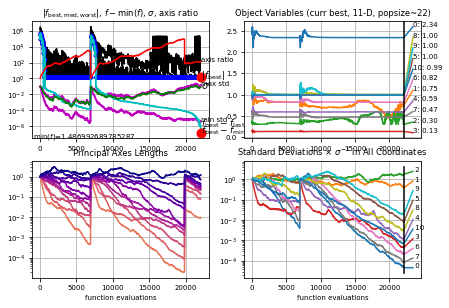

In [13]:
# Get problem configuration
conf = oad.FASTOADProblemConfigurator(CONFIGURATION_FILE)
prob = conf.get_problem(read_inputs=True, auto_scaling=True)

# CMA-ES Driver setup (see cma.CMAOptions() for all possible options for CMA-ES)
driver = prob.driver = CMAESDriver()
driver.options["sigma0"] = 0.1
driver.options[
    "penalty_parameter"
] = 1.0e6  # should be chosen such that f and the constraints violation have a similar magnitude.
driver.options["penalty_exponent"] = 1.0
driver.options["restarts"] = 1
driver.options["restart_from_best"] = True
driver.options["bipop"] = False
driver.CMAOptions["tolfun"] = 1e-6
driver.CMAOptions["tolfunhist"] = 1e-5
driver.CMAOptions["popsize_factor"] = 1
# driver.CMAOptions['CMA_stds'] = [1, 1, 100, 0.1, 0.1, 1, 1, 1, 1]
# driver.CMAOptions['CSA_dampfac'] = 1.  # positive multiplier for step-size damping
# driver.CMAOptions['CSA_squared'] = True
# driver.CMAOptions['integer_variables'] = [2]
# driver.options['augmented_lagrangian'] = True  # whether to use penalty method or augmented lagrangian for handling constraints

# Setup and run problem
prob.setup()
start_time = time()
prob.optim_failed = prob.run_driver()  # optimize
end_time = time()
computation_time = round(end_time - start_time, 2)
prob.write_outputs()

print("Objective function value ", driver.get_objective_values())

logger = cma.plot()  # plot logger

Let's save and visualize the optimization results:

In [15]:
OUTPUT_FILE = pth.join(WORK_FOLDER_PATH, "problem_outputs.xml")
DJI_M600_OUTPUT_FILE = pth.join(DATA_FOLDER_PATH, "problem_outputs_discrete_DJI_M600_mdo.xml")
shutil.copy(OUTPUT_FILE, DJI_M600_OUTPUT_FILE)
oad.optimization_viewer(CONFIGURATION_FILE)

D:\Softwares\poetry\cache\virtualenvs\fastuav-qz6dlUbG-py3.8\lib\site-packages\jupyter_client\session.py:716: UserWarning:

Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant



In [16]:
oad.variable_viewer(OUTPUT_FILE)

## 3. Analysis and plots

We may now compare the results from the optimization in the continuous domain with the off-the-shelf configuration:

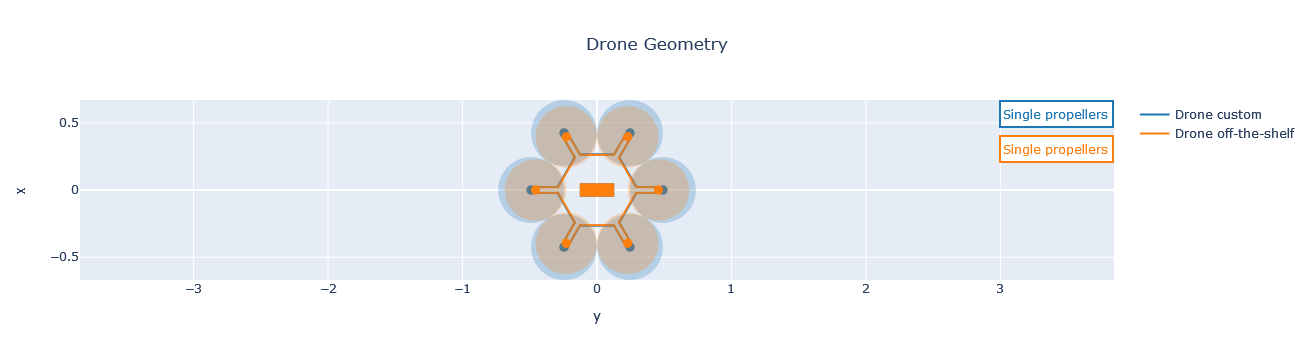

In [17]:
OUTPUT_FILE_CONTINUOUS = pth.join(DATA_FOLDER_PATH, "problem_outputs_DJI_M600_mdo.xml")
OUTPUT_FILE_DISCRETE = pth.join(DATA_FOLDER_PATH, "problem_outputs_discrete_DJI_M600_mdo.xml")
fig = multirotor_geometry_plot(OUTPUT_FILE_CONTINUOUS, name="Drone custom")
fig = multirotor_geometry_plot(OUTPUT_FILE_DISCRETE, name="Drone off-the-shelf", fig=fig)
fig.show()

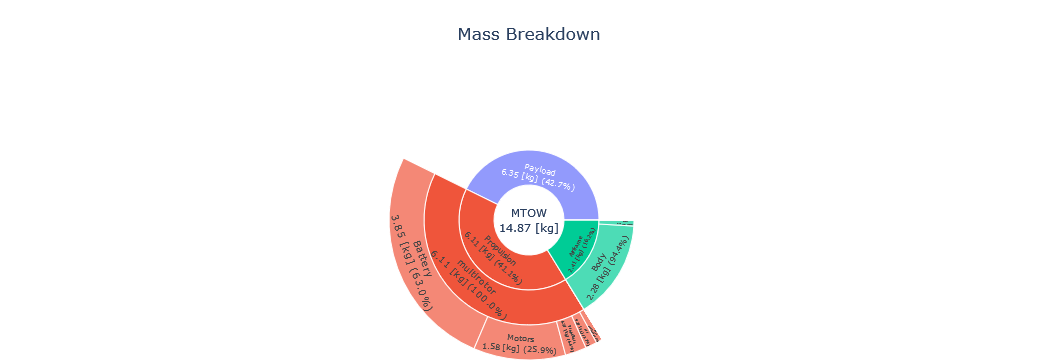

In [18]:
fig = mass_breakdown_sun_plot_drone(OUTPUT_FILE_DISCRETE)
fig.show()

In [14]:
#fig = mass_breakdown_bar_plot_drone(OUTPUT_FILE_CONTINUOUS, name="Drone custom")
#fig = mass_breakdown_bar_plot_drone(OUTPUT_FILE_DISCRETE, name="Drone off-the-shelf", fig=fig)
#fig.show()